In [1]:
import os
import sys

In [15]:
import pandas as pd
import numpy as np
from heagan.tools.functions import pymatgen_comp, data_generator
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from joblib import dump,load
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from importlib import resources
import onnxruntime as rt

In [5]:
with resources.files('heagan.dataset').joinpath('demo_dataset_true.csv') as fname:
    demo_df = pd.read_csv(fname,index_col = 0)
    demo_df

In [6]:
pmg_comps = pymatgen_comp(demo_df['Composition'].values)
dset = data_generator(pmg_comps, use_all_eles=False)
props_list = list(demo_df.columns[1:])
X = dset.real_data

RMSE : 0.003480331758747685
RMSE : 0.0022192743232751326
RMSE : 0.0014077007430758027
RMSE : 0.00141140009413166
RMSE : 0.0012679054475811275
RMSE : 0.04746667206688445
RMSE : 0.0014276637497659776


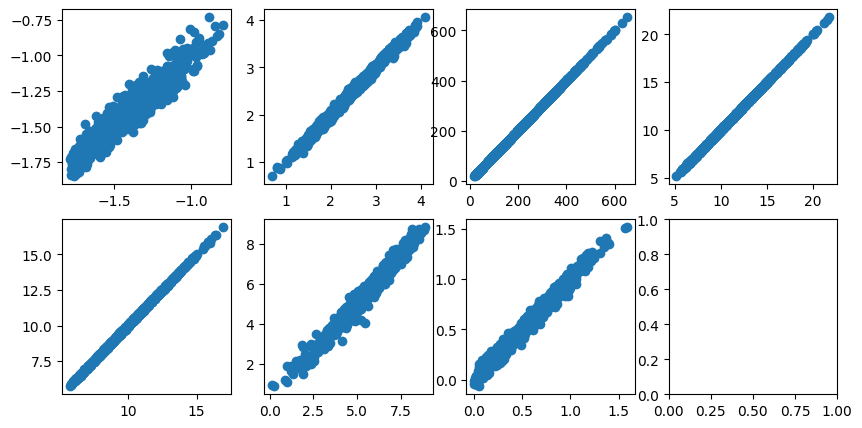

In [14]:
fig,ax = plt.subplots(2,4,figsize = (10,5))
ax = ax.ravel()
for i,p in enumerate(props_list):
    y = demo_df.loc[:,p].values
    X_train,X_test, y_train,y_test  = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
    #param_grid = {
    #      'activation': ['relu','tanh','logistic'],
    #      'alpha': [0.1,0.001,0.0001],
    #      'learning_rate': ['constant','adaptive'],
    #      'batch_size' : [16,32,64,128],
    #      'max_iter':[200,500]
    #      }
    net =MLPRegressor(hidden_layer_sizes=50, max_iter=500,batch_size=64, alpha = 1e-3)
    pipe = Pipeline([('Scaler', StandardScaler()),('MLPR',net)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    print(f'RMSE : {mean_squared_error(y_pred,y_test)}')
    ax[i].scatter(y_test,y_pred)
    model_path = f'../heagan/newSurrogates/surrogate_{p}.joblib'
    dump(pipe,model_path)

    onx = convert_sklearn(pipe, initial_types=[('X', FloatTensorType([None, X_train.shape[1]]))])
    with open(f'../heagan/newSurrogates/surrogate_{p}.onnx', "wb") as f:
        f.write(onx.SerializeToString())

X variable
RMSE : 0.003480331671455704
X variable
RMSE : 0.002219274397249819
X variable
RMSE : 0.001407661155297208
X variable
RMSE : 0.001411399838208453
X variable
RMSE : 0.0012679076489870073
X variable
RMSE : 0.04746667966771087
X variable
RMSE : 0.0014276639611876685


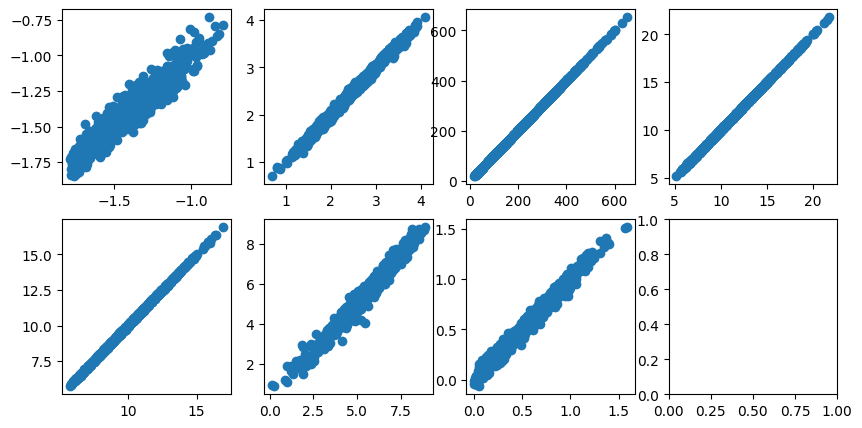

In [20]:
fig,ax = plt.subplots(2,4,figsize = (10,5))
ax = ax.ravel()

for i,p in enumerate(props_list):
    y = demo_df.loc[:,p].values
    X_train,X_test, y_train,y_test  = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)

    sess = rt.InferenceSession(f'../heagan/newSurrogates/surrogate_{p}.onnx')
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    print(input_name,label_name)
    y_pred = sess.run([label_name], {input_name: X_test.astype(np.float32)})[0]
    ax[i].scatter(y_test,y_pred)
    print(f'RMSE : {mean_squared_error(y_pred,y_test)}')

In [ ]:

    y_pred = pipe.predict(X_test)
    print(f'RMSE : {mean_squared_error(y_pred,y_test)}')
    ax[i].scatter(y_test,y_pred)
    model_path = f'../heagan/newSurrogates/surrogate_{p}.joblib'
    dump(pipe,model_path)